In [5]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from IPython.display import HTML

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import words
from nltk.corpus import wordnet 
allEnglishWords = words.words() + [w for w in wordnet.words()]
allEnglishWords = np.unique([x.lower() for x in allEnglishWords])
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models,layers
from statistics import median

from wordcloud import WordCloud, STOPWORDS
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import HTML, display
py.init_notebook_mode(connected=True)

#### Part A

In [8]:
data = [["RNN or LSTM","CNN"],
        
        ["RNNs are designed to make use of sequential data when the current step has some sort of relation with the previous steps. This makes them ideal for applications with time component like audio or time-series data and natural language processing"," Convolutions and pooling operations lose information about the local order of words so that sequence tagging as in PoS Tagging or Entity Extraction is a bit harder to fit into a pure CNN architecture. Pooling also reduces the output dimensionality but keeps the most salient information"],
       
        ["RNNs perform very well for applications where sequential information is clearly important because the meaning could be misinterpreted or the grammar could be incorrect if sequential information is not used.", 
        "We can use filter for detecting a specific feature such as detecting if the sentence contains a negation like “not good” for example. If this phrase occurs somewhere in the sentence, the result of applying the filter to that region will result in a large value, but a small value in other regions. By performing the max operation we are keeping information about whether or not the feature appeared in the sentence but are losing information about where exactly it appeared."]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

RNN or LSTM,CNN
RNNs are designed to make use of sequential data when the current step has some sort of relation with the previous steps. This makes them ideal for applications with time component like audio or time-series data and natural language processing,Convolutions and pooling operations lose information about the local order of words so that sequence tagging as in PoS Tagging or Entity Extraction is a bit harder to fit into a pure CNN architecture. Pooling also reduces the output dimensionality but keeps the most salient information
RNNs perform very well for applications where sequential information is clearly important because the meaning could be misinterpreted or the grammar could be incorrect if sequential information is not used.,"We can use filter for detecting a specific feature such as detecting if the sentence contains a negation like “not good” for example. If this phrase occurs somewhere in the sentence, the result of applying the filter to that region will result in a large value, but a small value in other regions. By performing the max operation we are keeping information about whether or not the feature appeared in the sentence but are losing information about where exactly it appeared."


#### Part B

Using the LSTM approach

In [9]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir,'train')
test_dir = os.path.join(imdb_dir,'test')
train_labels = []
train_texts = []

test_labels = []
test_texts = []

In [10]:
for label_type in ['pos','neg']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname))
            train_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)

In [11]:
for label_type in ['pos','neg']:
    dir_name = os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname))
            test_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)

In [12]:
texts_df = pd.DataFrame({'texts': train_texts,
                        'labels':train_labels})

In [13]:
texts_df.head()

,texts,labels
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [14]:
positive = texts_df[texts_df['labels']==1]['texts']
negative = texts_df[texts_df['labels']==0]['texts']

<Figure size 432x288 with 0 Axes>

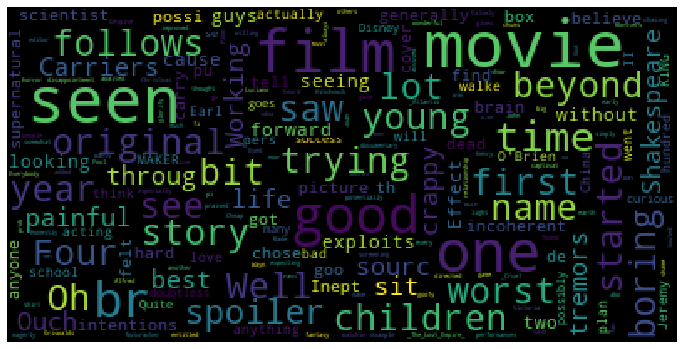

In [15]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='black',
                      stopwords=stopwords,
                      max_words=200,
                      max_font_size=40, 
                      random_state=42
                      ).generate(str(negative))

print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word.png", dpi=900)

In [16]:
MAX_LENGTH = 500
MAX_WORDS = 20000
EMBENDING_DIM = 100

In [18]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

In [19]:
word_index = tokenizer.word_index

In [20]:
print(f'Found {len(word_index)} unique tokens.' )

Found 88582 unique tokens.


In [20]:
data = pad_sequences(sequences,maxlen=MAX_LENGTH)
labels = np.array(train_labels)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(data,labels,test_size=0.2,random_state=42)

In [27]:
glove_dir = "glove.6B.100d.txt"
embedding_index = {}
f = open(glove_dir)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [28]:
embedding_index['go'][:10]

array([-0.078894,  0.4616  ,  0.57779 , -0.71637 , -0.13121 ,  0.4186  ,
       -0.29156 ,  0.52006 ,  0.089986, -0.35062 ], dtype=float32)

In [29]:
embedding_matrix = np.zeros((MAX_WORDS,EMBENDING_DIM))

In [30]:
for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [31]:
embedding_df = pd.DataFrame(embedding_matrix)

In [36]:
model = models.Sequential()
model.add(layers.Embedding(MAX_WORDS,EMBENDING_DIM, input_length=MAX_LENGTH))
model.add(layers.LSTM(32))
model.add(layers.Dense(5))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 2,017,195
Trainable params: 2,017,195
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [38]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.5555 - acc: 0.7125 - val_loss: 0.4493 - val_acc: 0.7924
Epoch 2/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.4297 - acc: 0.8029 - val_loss: 0.3814 - val_acc: 0.8370
Epoch 3/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.3678 - acc: 0.8383 - val_loss: 0.3449 - val_acc: 0.8546
Epoch 4/10
20000/20000 [==============================] - 689s 34ms/step - loss: 0.3323 - acc: 0.8569 - val_loss: 0.3346 - val_acc: 0.8578
Epoch 5/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.3065 - acc: 0.8716 - val_loss: 0.3222 - val_acc: 0.8674
Epoch 6/10
20000/20000 [==============================] - 339s 17ms/step - loss: 0.2850 - acc: 0.8796 - val_loss: 0.3021 - val_acc: 0.8746
Epoch 7/10
20000/20000 [==============================] - 90s 5ms/step - loss: 0.2676 - acc: 0.8889 - val_loss: 0.2967 - val_

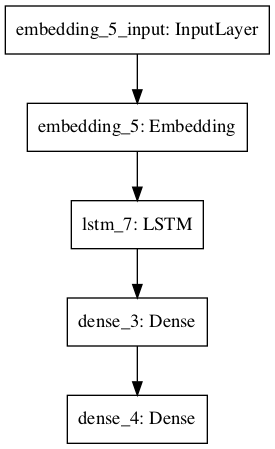

In [40]:
keras.utils.plot_model(model, show_layer_names=True, to_file='sentiment.png')

In [41]:
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences,maxlen=MAX_LENGTH)
test_labels = np.array(test_labels)

In [42]:
predictions = model.predict(test_data)

In [43]:
pred_proba = model.predict_proba(test_data)

In [44]:
pred_labels  = (predictions>0.5)

Text(15.380000000000003, 0.5, 'predicted label')

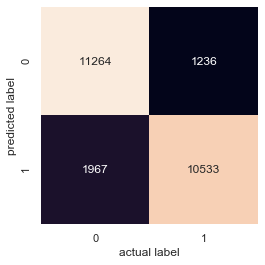

In [45]:
mat = confusion_matrix(pred_labels, test_labels)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('actual label')
plt.ylabel('predicted label')

In [46]:
print(classification_report(test_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     12500
           1       0.89      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [47]:
EPOCHS = 10
x = np.arange(EPOCHS)
history = model.history.history

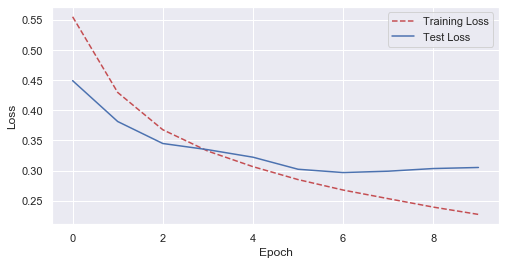

In [48]:
# Get training and test loss histories
training_loss = history['loss']
test_loss = history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(x, training_loss, 'r--')
plt.plot(x, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

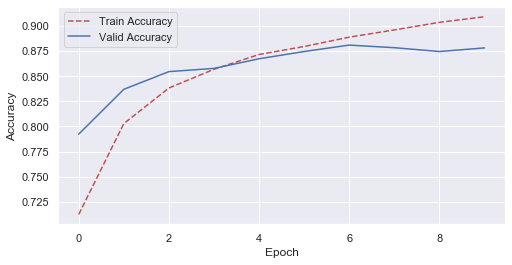

In [49]:
# Get accuracy 
training_accuracy = history["acc"]
validation_accuracy = history["val_acc"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(x, training_accuracy, 'r--')
plt.plot(x, validation_accuracy, 'b-')
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()